# pbh

> A module to model and calculate the properties of primordial black holes (PBHs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp pbh

In [2]:
#| hide
from nbdev.showdoc import *

In [1]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *
from LensCalcPy.galaxy import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad, dblquad, tplquad
from scipy.optimize import minimize_scalar, fsolve, brentq
from scipy.integrate import quad


from scipy.interpolate import interp1d, interp2d, RegularGridInterpolator
from tqdm import tqdm
# from multiprocessing import Pool
from pathos.multiprocessing import ProcessingPool as Pool
import functools
import pickle
from abc import ABC, abstractmethod

from fastcore.test import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def A_ps(u):
    return (u**2 + 2) / (u * (u**2 + 4)**(1/2))

def f_func(x):
    return (2 + x)/(x*(4+x))**(0.5) - 1

def t_fwhm_gondolo(t_e, umin):
    deltab = f_func(umin**2)
    bw2 = 2* f_func(deltab)
    w_b = 2*(bw2 - umin**2)**(1/2)
    return w_b * t_e

def t_E_from_t_fwhm(t_fwhm, umin):
    deltab = f_func(umin**2)
    bw2 = 2* f_func(deltab)
    w_b = 2*(bw2 - umin**2)**(1/2)
    return t_fwhm / w_b

def ellip(phi, m):
    return quad(lambda x: np.sqrt(1 - m**2*np.sin(x)**2), 0, phi)[0]

def theta_max(u, rho):
    if u <= rho:
        return np.pi/2
    else:
        return np.arcsin(rho/u)

def A_gould(u, rho):
    return A_ps(u) * 4*u / (np.pi * rho) * ellip(theta_max(u, rho), u/rho)

def f_func_finite(u, rho):
    return A_gould(u, rho) - 1

def t_fwhm_gondolo(t_e, umin):
    deltab = f_func(umin**2)
    bw2 = 2* f_func(deltab)
    w_b = 2*(bw2 - umin**2)**(1/2)
    return w_b * t_e

def t_fwhm_gondolo_finite(t_e, umin, rho):
    func = lambda b: f_func_finite(b,rho) - f_func_finite(umin**2,rho)*0.5
    bw = fsolve(func,1)[0]
    w_b = 2*(bw**2 - umin**2)**(1/2)
    return w_b * t_e

# def t_E_from_t_fwhm_finite(t_fwhm, umin, rho):
#     if rho >=10:
#         return t_fwhm/rho/2
#     func = lambda b: f_func_finite(b,rho) - f_func_finite(umin**2,rho)*0.5
#     bw = fsolve(func,1)[0]
#     w_b = 2*(bw**2 - umin**2)**(1/2)
#     return t_fwhm / w_b

def t_E_from_t_fwhm_finite(t_fwhm, umin, rho):
    if rho >=1:
        return t_fwhm/rho/2
    return t_E_from_t_fwhm(t_fwhm, umin)

def magnification_finite_new(u, rho):
    integrand = lambda r, theta: integrand_polar(r, theta, u)
    result, _ = nquad(integrand, [[0, rho], [0, 2 * np.pi]])
    return result / (np.pi * rho**2)

def t_fwhm(t_e, umin, finite, rho=None, ut=1):
    if not finite:
        return t_fwhm_gondolo(t_e, umin)
    else:
        Amax = 1 + 1/rho
        # u_fwhm = ut_func_new(rho, 1+(1-Amax)/2)[0]
        u_fwhm = u_fwhm_interp([rho, umin])[0]
        if u_fwhm<=umin:
            return 0
        return 2*(u_fwhm**2 - umin**2)**(1/2) * t_e
    
def t_e_from_fwhm(t_fwhm, umin, finite, rho=None, ut=1):
    if not finite:
        return t_fwhm / t_fwhm_gondolo(1, umin)
    else:
        # Amax = 1 + 1/rho
        # u_fwhm = ut_func_new(rho, 1+(1-Amax)/2)[0]
        # u_fwhm = fast_u_fwhm_func(rho, umin)
        u_fwhm = u_fwhm_interp([rho, umin])[0]
        if u_fwhm<=umin:
            print('u_fwhm<=umin')
            return 1e-3
        return t_fwhm / (2*(u_fwhm**2 - umin**2)**(1/2))
    
def u_fwhm_func(rho, umin):
    Amax = magnification_finite_new(umin, rho)
    func = lambda u: magnification_finite_new(u, rho) - (1+(1-Amax)/2)
    return fsolve(func, 1, xtol=1e-2)[0]

def t_duration(t_e, umin, finite, rho=None, ut=1):
    if not finite:
        return 2*(ut**2 - umin**2)**(1/2) * t_e
    else:
        if ut_func_new(rho, 1.34)[0] <= umin:
            return 0
        return (2*(ut_func_new(rho, 1.34)**2 - umin**2)**(1/2) * t_e)[0]


In [ ]:
u_vals = np.logspace(-2, 1, 100)
rho_vals = np.logspace(-2, 1, 100)
z_vals = np.array([[magnification_finite_new(u, rho) for u in u_vals] for rho in rho_vals])

In [ ]:
# mag_finite_interp = RegularGridInterpolator((rho_vals, u_vals), z_vals, method='linear', bounds_error=False, fill_value=None)

def fast_magnification_finite_new(u, rho):
    return mag_finite_interp([float(rho), float(u)])
    
def fast_u_fwhm_func(rho, umin):
    Amax = fast_magnification_finite_new(umin, rho)
    if Amax<1:
        return 0
    func = lambda u: fast_magnification_finite_new(u, rho) - (1+(Amax-1)/2)
    return fsolve(func, 1)

In [1252]:
# z_u_vals = np.array([[fast_u_fwhm_func(rho, u) for u in u_vals] for rho in rho_vals])
# u_fwhm_interp = RegularGridInterpolator((rho_vals, u_vals), z_u_vals, method='linear', bounds_error=False, fill_value=None)


/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_35054/3382273810.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return mag_finite_interp([float(rho), float(u)])


In [1279]:
umin_arr = np.logspace(-1, 0.4, 100)
rho= 1
fast_Amax_arr = np.array([fast_magnification_finite_new(umin, rho) for umin in umin_arr])

fast_uhm_arr = np.array([u_fwhm_interp([rho, umin]) for umin in umin_arr])
ut_arr = np.array([ut_func_new(1.2, Amax) for Amax in fast_Amax_arr])
uhm_arr = np.array([ut_func_new(1.2, 1+(Amax-1)/2) for Amax in fast_Amax_arr])
uhm_point_arr = np.array([(2* f_func(f_func(umin**2)))**(1/2) for umin in umin_arr])

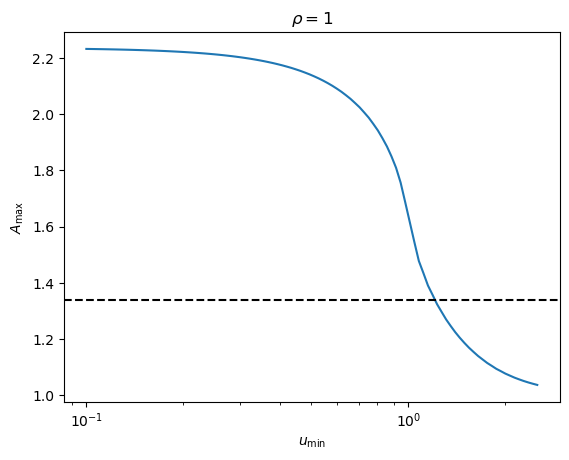

In [1280]:
# plt.plot(umin_arr, Amax_arr)
plt.plot(umin_arr, fast_Amax_arr)
plt.axhline(1.34, color='k', linestyle='--')
plt.xlabel(r'$u_{\rm min}$')
plt.ylabel(r'$A_{\rm max}$')
plt.title(r'$\rho = $' + str(rho))
plt.xscale('log')
plt.show()

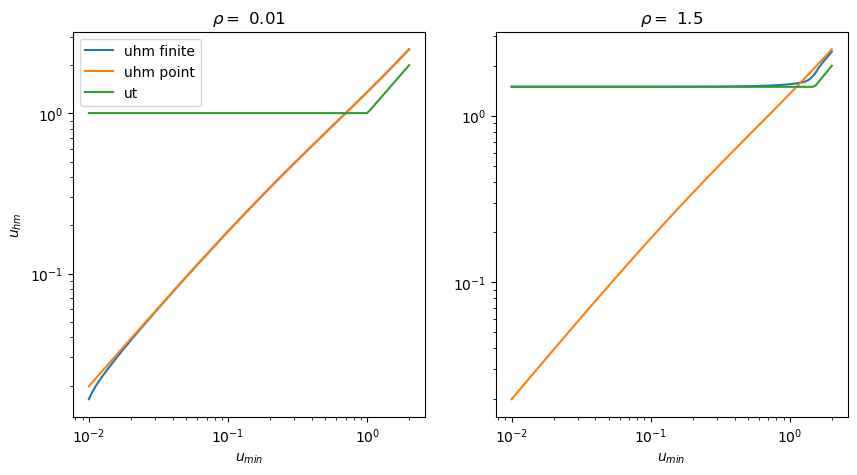

In [1402]:
plt.figure(figsize=(10,5))
plt.subplot(121)

rho= 0.01
fast_uhm_arr = np.array([u_fwhm_interp([rho, umin])[0] for umin in umin_arr])
uhm_point_arr = np.array([(2* f_func(f_func(umin**2)))**(1/2) for umin in umin_arr])
fast_Amax_arr = np.array([fast_magnification_finite_new(umin, rho) for umin in umin_arr])
ut_arr = np.array([ut_func_new(rho, Amax) for Amax in fast_Amax_arr])
plt.plot(umin_arr, fast_uhm_arr, label='uhm finite')
plt.plot(umin_arr, uhm_point_arr, label='uhm point')
plt.plot(umin_arr, ut_arr, label='ut')

plt.xlabel(r'$u_{min}$')
plt.ylabel(r'$u_{hm}$')
plt.title(r'$\rho = $ ' + str(rho))
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.subplot(122)
rho= 1.5
fast_uhm_arr = np.array([u_fwhm_interp([rho, umin])[0] for umin in umin_arr])
uhm_point_arr = np.array([(2* f_func(f_func(umin**2)))**(1/2) for umin in umin_arr])
fast_Amax_arr = np.array([fast_magnification_finite_new(umin, rho) for umin in umin_arr])
ut_arr = np.array([ut_func_new(rho, Amax) for Amax in fast_Amax_arr])
plt.plot(umin_arr, fast_uhm_arr, label='uhm finite')
plt.plot(umin_arr, uhm_point_arr, label='uhm point')
plt.plot(umin_arr, ut_arr, label='ut')

plt.xlabel(r'$u_{min}$')
plt.title(r'$\rho = $ ' + str(rho))
plt.xscale('log')
plt.yscale('log')
plt.show()


In [1429]:
rho = 2.1
# rho = 0.01

ut = 1
umin_arr = np.logspace(np.log10(0.01), np.log10(2), 100)
tfwhm_arr = np.array([t_fwhm(10, umin, True, rho, ut_func_new(rho, 1.34)) for umin in umin_arr])
tfwhm_arr_point = np.array([t_fwhm(10, umin, False, rho, ut_func_new(rho, 1.34)) for umin in umin_arr])
t_duration_arr = np.array([t_duration(10, umin, True, rho,  1) for umin in umin_arr])

rho_arr = np.linspace(0.01, 3, 100)
tfwhm_arr2 = np.array([t_fwhm(10, 0.1, True, rho, ut_func_new(rho, 1.34)) for rho in rho_arr])
tfwhm_arr_point2 = np.array([t_fwhm(10, 0.1, False, rho, ut_func_new(rho, 1.34)) for rho in rho_arr])
t_duration_arr2 = np.array([t_duration(10, 0.1, True, rho, 1) for rho in rho_arr])

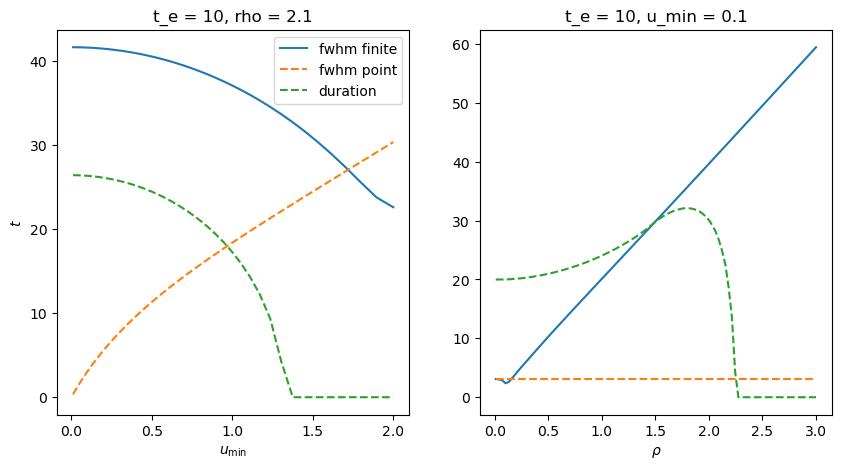

In [1430]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('t_e = 10, rho = {}'.format(rho))

plt.plot(umin_arr, tfwhm_arr, label='fwhm finite')
plt.plot(umin_arr, tfwhm_arr_point, label = 'fwhm point', linestyle='--')
plt.plot(umin_arr, t_duration_arr, label='duration', linestyle='--')
plt.ylabel(r'$t$')
plt.xlabel(r'$u_{\rm min}$')
# plt.xscale('log')
plt.legend()
plt.subplot(122)
plt.plot(rho_arr, tfwhm_arr2)
plt.plot(rho_arr, tfwhm_arr_point2, linestyle='--')
plt.plot(rho_arr, t_duration_arr2, linestyle='--')
plt.title(r't_e = 10, u_min = 0.1')
plt.xlabel(r'$\rho$')
plt.show()

In [1620]:
from scipy.integrate import quad_vec

In [29]:
#| export


class Pbh(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                mass: float, # PBH mass in solar masses
                f_dm: float, # PBH fraction of the DM density
                mw_model=None,
                m31_model=None,
                l = None,
                b = None,
                u_t = 1,
                ds = 770,
                lognorm=False,
                sigma=None
                ):
        """
        Initialize the PBH population
        """

        self.mw_model = mw_model or MilkyWayModel(mw_parameters)
        self.m31_model = m31_model or M31Model(m31_parameters)
        
        if l is None:
            raise ValueError("Galactic longitude must be specified")
        if b is None:
            raise ValueError("Galactic latitude must be specified")
        self.l = l
        self.b = b

        self.mass = mass
        if f_dm < 0 or f_dm > 1:
            raise ValueError("f_dm must be between 0 and 1")
        self.f_dm = f_dm
        # self.ut_interp = ut_interp
        self.ut_interp = ut_func_new
        self.u_t = u_t
        self.ds = ds
        self.lognorm = lognorm
        if self.lognorm and sigma is None:
            raise ValueError("Sigma must be specified for lognormal mass function")
        self.sigma = sigma
    
    def __str__(self) -> str:
        return f"PBH population with mass={self.mass} and f_dm={self.f_dm}"
    __repr__ = __str__

    def mass_function(self, m):
        """The mass function of the PBH population"""
        if not self.sigma or not self.lognorm:
            raise ValueError("Lognormal mass function not initialized")
        return 1 / (m * self.sigma * np.sqrt(2 * np.pi)) * np.exp(-(np.log(m/self.mass))**2 / (2 * self.sigma**2))

    def differential_rate_integrand(self, umin, d, t, model, finite=False, v_disp=None, t_e = False, tmax=np.inf, tmin=0, t_fwhm=False):

        r = model.dist_center(d, self.l, self.b)
        ut = self.umin_upper_bound(d) if finite else self.u_t
        if ut <= umin:
            return 0
        if t_e: 
            #Calculate radial velocity in terms of einstein crossing time
            v_rad = einstein_rad(d, self.mass, self.ds) * kpctokm / (t * htosec) 
            t_duration = max(ut, self.umin_upper_bound(d)) * 2 * einstein_rad(d, self.mass) * kpctokm / v_rad / htosec #event duration in hours

            if t_duration > tmax or t_duration < tmin:
                return 0   
        elif t_fwhm:
            # if finite:
            #     t_E = t_E_from_t_fwhm_finite(t, umin, rho_func(self.mass, d, self.ds))
            # else:
            #     t_E = t_E_from_t_fwhm(t, umin)
            t_E = t_e_from_fwhm(t, umin, finite, rho_func(self.mass, d, self.ds), ut)
            # t_E = t_e_from_fwhm(t, umin, True, rho_func(self.mass, d, self.ds), ut)

            v_rad = einstein_rad(d, self.mass, self.ds) * kpctokm / (t_E * htosec)
        else:
            #Calculate radial velocity in terms of event duration (t_fwhm)
            v_rad = velocity_radial(d, self.mass, umin, t * htosec, ut) 
        if v_disp is None: 
            v_disp = model.velocity_dispersion_dm(r)
            # v_disp = model.velocity_dispersion_nfw(r)

        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                model.density_dm(d, self.l, self.b) / (self.mass * v_disp**2) *  
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)) *
                1)

    def differential_rate_integrand_mw(self, umin, d, t, finite=False):
        return self.differential_rate_integrand(umin, d, t, self.mw_model, finite=finite)
    
    def differential_rate_integrand_m31(self, umin, d, t, finite=False):
        return self.differential_rate_integrand(umin, d, t, self.m31_model, finite=finite)
    
    def differential_rate(self, t, integrand_func, finite=False, epsabs=1.49e-08, epsrel=1.49e-08):
        # if finite:
        #     result, error = dblquad(integrand_func, 
        #                             0, self.d_upper_bound(),
        #                             lambda d: 0, 
        #                             lambda d: self.umin_upper_bound(d),
        #                             args=[t],
        #                             epsabs=0,
        #                             epsrel=1e-1,
        #                             )
        # else:
        #     result, error = dblquad(integrand_func,
        #                                 #Without finite size effects, integral blows up at M31 center
        #                             0, self.ds*0.99,
        #                             # 0, self.d_upper_bound(),
        #                             lambda d: 0, 
        #                             lambda d: self.u_t,
        #                             args=[t],
        #                             epsabs=0,
        #                             epsrel=1e-1,
        #                             )
        # return result

        def inner_integrand(u, d, t):
            return integrand_func(u, d, t)
        
        # Second integral (over u) - bounds given by d
        def second_integral(d, t):
            if finite:
                u_min, u_max = 0, self.umin_upper_bound(d)[0]
            else:
                u_min, u_max = 0, self.u_t

            result, error = quad(inner_integrand, u_min, u_max, args=(d, t), epsabs=epsabs, epsrel=epsrel)

            return result
        
        # Outermost integral (over d)
        d_min, d_max = 0, self.d_upper_bound() if finite else self.ds
        result, error = quad(second_integral, d_min, d_max, args=(t,), epsabs=epsabs, epsrel=epsrel)
        return result

    def rate_total(self, integrand_func, finite=True, tcad=0.07, tobs=3, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None):        
        
        # if efficiency is None:
        #     def efficiency(t):
        #         return 1
            
        # point = self.sticking_point()

        # def integrand(t, d, finite):
        #     if finite:
        #         u_bounds = [0, self.umin_upper_bound(d)]
        #     else:
        #         u_bounds = [0, self.u_t]
        #     u_result, _ = nquad(integrand_func, [u_bounds], args=(d, t))
        #     return u_result * efficiency(t)

        # bounds_t = [tcad, tobs]

        # if finite:
        #     bounds_d = [0, min(self.d_upper_bound(), self.ds)]
        # else:
        #     bounds_d = [0, self.ds]

        # opts = {"epsabs": epsabs, "epsrel": epsrel, "points":[point, self.ds]}

        # result, error = nquad(integrand, [bounds_t, bounds_d], args=[finite], opts=opts)
        # return result

        # Innermost double integral
        def inner_integrand(u, d, t):
            return integrand_func(u, d, t)
        
        # Second integral (over u) - bounds given by d
        def second_integral(d, t):
            if finite:
                u_min, u_max = 0, self.umin_upper_bound(d)[0]
            else:
                u_min, u_max = 0, self.u_t
            
            result, error = quad(inner_integrand, u_min, u_max, args=(d, t), epsabs=epsabs, epsrel=epsrel)

            return result
        
        # Outermost integral (over d)
        def outer_integral(t):
            d_min, d_max = 0, self.d_upper_bound() if finite else self.ds
            result, error = quad(second_integral, d_min, d_max, args=(t,), epsabs=epsabs, epsrel=epsrel)
            # return result * self.mass_function(mf) * mf * np.log(10)  # multiply by mass function and by dlogm * m
            return result  
        
        # Integrate over time
        result, error = quad(outer_integral, tcad, tobs, epsabs=epsabs, epsrel=epsrel)
        return result
    
    
    def d_upper_bound(self, m=None):
        if m is None:
            m = self.mass
        #Determine upper limit for d otherwise for low masses, the contribution which only comes from d << 1 gets missed
        d_arr = np.logspace(-3, np.log10(self.ds*0.99), 100)
        for d in d_arr:
            if self.umin_upper_bound(d,m=m) == 0:
                return d
        return self.ds
    
    def rate_mw(self, finite=False, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08):
        def integrand_func(umin, d, t):
            return self.differential_rate_integrand_mw(umin, d, t, finite=finite,)
        return self.rate_total(integrand_func, finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel)
    
    def rate_m31(self, finite=False):
        result = self.rate_total(self.differential_rate_integrand_m31, finite=finite)
        if not np.isnan(result):
            return result
        else:
            return 0
        
    def rate_tot(self, finite=False):
        return self.rate_mw(finite=finite) + self.rate_m31(finite=finite)
    
    def differential_rate_mw(self, t, finite=True, v_disp=None, t_e=False, tmax=np.inf, tmin=0, t_fwhm=False):
        def integrand_func(umin, d, t):
            return self.differential_rate_integrand(umin, d, t, self.mw_model, finite=finite, v_disp=v_disp, t_e = t_e, tmax=tmax, tmin=tmin, t_fwhm=t_fwhm)
        return self.differential_rate(t, integrand_func, finite=finite)
    
    def differential_rate_m31(self, t, finite=True, v_disp=None, t_fwhm=False):
        def integrand_func(umin, d, t):
            return self.differential_rate_integrand(umin, d, t, self.m31_model, finite=finite, v_disp=v_disp, t_fwhm=t_fwhm)
        return self.differential_rate(t, integrand_func, finite=finite)

    def umin_upper_bound(self, d, m=None):
        if m is None:
            m = self.mass
        rho = rho_func(m, d, self.ds)
        return self.ut_interp(rho, magnification(self.u_t))
    
    def differential_rate_total(self, t, finite=True):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]
    
    def sticking_point(self):
        #Determine where u_t is maximized. This speeds up the integral in m31
        result = minimize_scalar(lambda d: -self.umin_upper_bound(d), bounds=(0, self.ds), method='bounded')
        if result.success:
            return result.x[0] if isinstance(result.x, (list, np.ndarray)) else result.x
        else:
            return self.ds
    
    def differential_rate_integrand_lognorm(self, umin, d, t, mf, model, finite=False, v_disp=None, t_e = False, tmax=np.inf, tmin=0):

        r = model.dist_center(d, self.l, self.b)
        ut = self.umin_upper_bound(d) if finite else self.u_t
        if ut <= umin:
            return 0 
        
        #Calculate radial velocity in terms of event duration 
        v_rad = velocity_radial(d, mf, umin, t * htosec, ut) 
        if v_disp is None: 
            v_disp = model.velocity_dispersion_dm(r)
        # if v_rad/v_disp > 10:
            # return 0
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                model.density_dm(d, self.l, self.b) / (mf * v_disp**2) *  
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)) *
                1)
    
    def differential_rate_lognorm(self, t, integrand_func, finite=False, epsabs=1.49e-08, epsrel=1.49e-08):
    
        # Innermost double integral
        def inner_integrand(u, d, mf, t):
            return integrand_func(u, d, mf, t)
        
        # Second integral (over u) - bounds given by d
        def second_integral(d, mf, t):
            if finite:
                u_min, u_max = 0, self.umin_upper_bound(d, mf)[0]
            else:
                u_min, u_max = 0, self.u_t

            if 2/3 * u_max**2 < self.mw_model.velocity_dispersion_dm(self.mw_model.dist_center(d, self.l, self.b))**2:
                local_max = u_max
            else:
                local_max = 1.22* (2/3*u_max**2 - self.mw_model.velocity_dispersion_dm(self.mw_model.dist_center(d, self.l, self.b))**2)**(1/2)
            
            # result, error = quad(inner_integrand, u_min, u_max, args=(d, mf, t), epsabs=epsabs, epsrel=epsrel, points=[0, u_max/2, 1], limit=3)
            result, error = quad(inner_integrand, u_min, u_max, args=(d, mf, t), epsabs=epsabs, epsrel=epsrel, points=[local_max])

            return result
        
        # Outermost integral (over d)
        def outer_integral(mf, t):
            d_min, d_max = 0, self.d_upper_bound(mf) if finite else self.ds
            result, error = quad(second_integral, d_min, d_max, args=(mf, t), epsabs=epsabs, epsrel=epsrel)
            # return result * self.mass_function(mf) * mf * np.log(10)  # multiply by mass function and by dlogm * m
            return result * self.mass_function(mf)   

        # Integrate over mass
        mf_min, mf_max = 10**(np.log10(self.mass) - 3 * self.sigma), 10**(np.log10(self.mass) + 3 * self.sigma)
        result, error = quad(outer_integral, mf_min, mf_max, args=(t,), epsabs=epsabs, epsrel=epsrel)
        
        return result
    
    def differential_rate_mw_lognorm(self, t, finite=True, v_disp=None, t_e=False, tmax=np.inf, tmin=0, epsabs = 1.49e-08, epsrel = 1.49e-08):
        def integrand_func(umin, d, mf, t):
            return self.differential_rate_integrand_lognorm(umin, d, t, mf, self.mw_model, finite=finite, v_disp=v_disp, t_e = t_e, tmax=tmax, tmin=tmin)
        return self.differential_rate_lognorm(t, integrand_func, finite=finite, epsabs = epsabs, epsrel = epsrel)

In [55]:
magnification(3.5)

1.009997124512126

In [82]:
rho_arr = np.logspace(-2, 0.5, 100)
A_t = 1.34
my_ut_arr = np.array([ut_func_new(rho, A_t) for rho in rho_arr])
j_ut_arr = np.array([max(1, 2*rho) for rho in rho_arr])
j_ut_alt_arr = np.array([max(3, 2*rho) for rho in rho_arr])


Text(0, 0.5, '$u_{\\rm T}$')

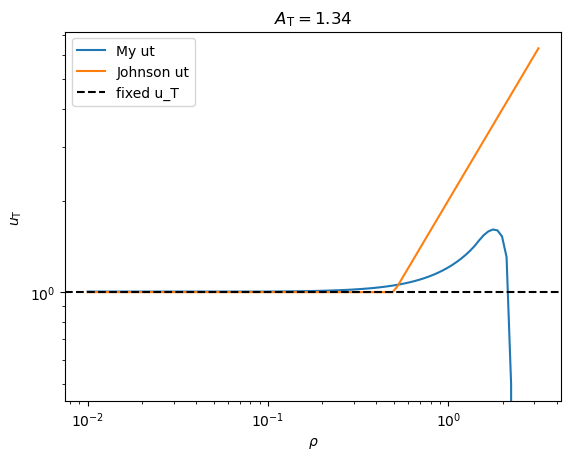

In [85]:
plt.plot(rho_arr, my_ut_arr, label='My ut')
plt.plot(rho_arr, j_ut_arr, label='Johnson ut')
plt.axhline(1., color='k', linestyle='--', label='fixed u_T')
# plt.loglog(rho_arr, j_ut_alt_arr, label='Johnson ut alt')
plt.title(r'$A_{\rm T} = $' + str(A_t))
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$u_{\rm T}$')


In [30]:
m_lens = 3e-6
# pbh = Pbh(m_lens, 1, l=l, b=b, ds=ds)
pbh = Pbh(m_lens, 1, l=1.0, b=-1.03, ds=8.5, lognorm=True, sigma=0.1, u_t=1)
ts = np.logspace(-2,1,50)

In [22]:
u_t_arr = np.linspace(0.1, 10, 20)
rate_earth = []
for u_t in tqdm(u_t_arr):
    pbh.u_t = u_t
    rate_earth.append(pbh.rate_mw(finite=True, tcad = 0.25, tobs = 6*72*24, efficiency=None, epsabs=0, epsrel=1e-1))
diff_rate_earth_log_un_1 = np.array(rate_earth)

  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_14520/3093321778.py:178: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(inner_integrand, u_min, u_max, args=(d, t), epsabs=epsabs, epsrel=epsrel)
 15%|█▌        | 3/20 [06:50<39:31, 139.52s/it]/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_14520/3093321778.py:190: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(outer_integral, tcad, tobs, epsabs=epsabs, epsrel=epsrel)
100%|██████████| 20/20 [50:01<00:00, 150.06s/it]


In [24]:
rate_earth[-1]/rate_earth[0]

4.170278252559508

Text(0, 0.5, '$\\Gamma$')

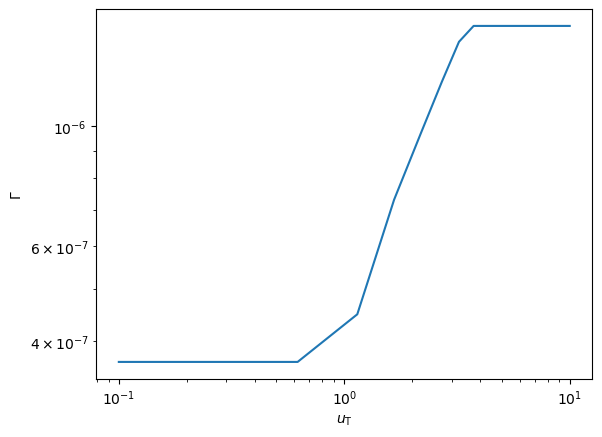

In [23]:
plt.loglog(u_t_arr, rate_earth)
plt.xlabel(r'$u_{\rm T}$')
plt.ylabel(r'$\Gamma$')

Text(0, 0.5, '$d\\Gamma/dt$')

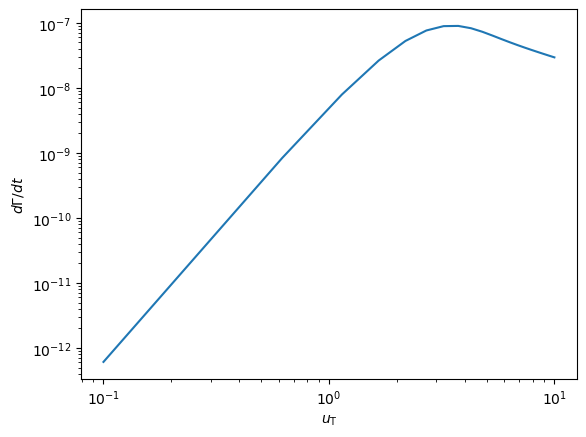

In [21]:
plt.loglog(u_t_arr, diff_rate_earth)
plt.xlabel(r'$u_{\rm T}$')
plt.ylabel(r'$d\Gamma/dt$')

In [36]:
0.9*8.5

7.65

In [37]:
Rs_pc = 2.3e-8
G_pc = 4.3e-3
ds_pc = 8.5e3
# dl_pc = 0.9*ds_pc # Try 3/4 of the way to the source instead
dl_pc = 7e3
print(Rs_pc**2 / (4 * G_pc * ds_pc) *(dl_pc/ds_pc)*(3e5)**2/(3e-6) )
print(Rs_pc**2 / (4 * G_pc * ds_pc*(1-dl_pc/ds_pc)) *(dl_pc/ds_pc)*(3e5)**2/2 ) #Location in solar masses


0.08939406131809767
7.598495212038302e-07


In [126]:
pbh.differential_rate_mw_lognorm(1, finite=True)

1.4340302747434424e-07

In [31]:
#new rate_tot
pbh.rate_mw(finite=True, tcad = 0.25, tobs = 6*72*24, efficiency=None, epsabs=0, epsrel=1e-1)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_14520/3093321778.py:178: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(inner_integrand, u_min, u_max, args=(d, t), epsabs=epsabs, epsrel=epsrel)


3.6666755430044117e-07

In [122]:
ts = np.logspace(np.log10(0.25), np.log10(6*72*24), 80)
dgdt_arr = np.array([pbh.differential_rate_mw(t, finite=True) for t in tqdm(ts)])

  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 80/80 [00:09<00:00,  8.50it/s]


In [123]:
dgdt_interp = interp1d(ts, dgdt_arr, kind='linear')

In [124]:
quad(dgdt_interp, 0.25, 6*72*24, epsabs=0, epsrel=1e-1)[0]

2.75728017455747e-07

In [ ]:
# rate and differential rate integrated agree, phew!

In [152]:
1.8287449449840167e-07* 2.4e8 * 6*72*24

455050.26215026283

In [154]:
6*72*24

10368

In [142]:
print(pbh.differential_rate_mw(10, finite=True))
print(pbh.differential_rate_mw(1, finite=True))
print(pbh.differential_rate_mw(.1, finite=True))


# print(pbh.differential_rate_m31(1, finite=True))


3.350673819470154e-11
1.473759952169556e-07
1.0871773308725574e-07


In [153]:
diff_rate_mono[argmax_idx] * ts[argmax_idx]

1.2615301177094811e-06

In [150]:
argmax_idx = np.argmax(diff_rate_mono)
print(diff_rate_mono[argmax_idx] * ts[argmax_idx]* 2.4e8 * 6*72*24)
# 2.4e-6 * 0.5 * 2.4e8 * 6*72*24

3139090.622498856


In [1691]:
def integrand_func(umin, d, mf, t):
    return pbh.differential_rate_integrand_lognorm(umin, d, t, mf, pbh.mw_model, finite=True, v_disp=None, t_e = False)
ts = np.logspace(-2,1,50)
us = np.linspace(0, 1.43, 100)
integrand_vals_t = np.array([integrand_func(0.1, 1, 1e-8, t) for t in ts])
integrand_vals_u = np.array([integrand_func(umin, 1, 1e-8, 0.1) for umin in us])


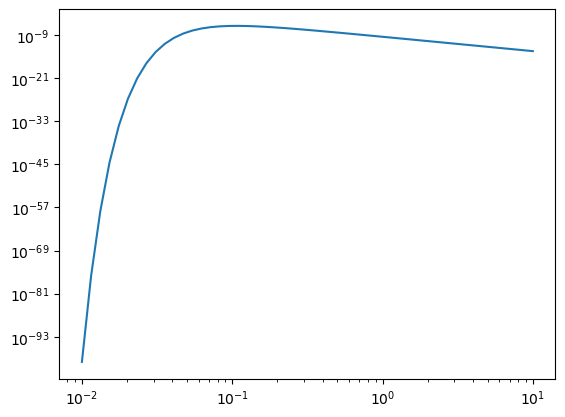

In [1693]:
plt.loglog(ts, integrand_vals_t)

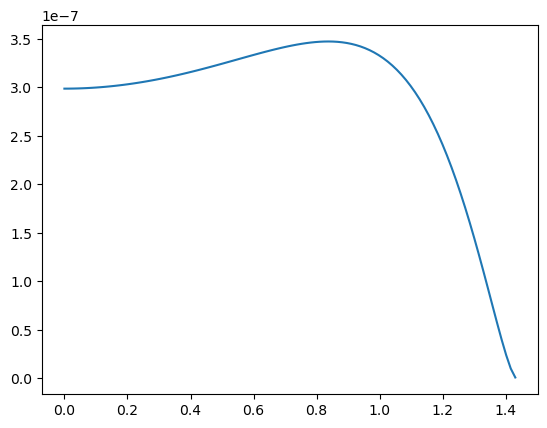

In [1703]:
plt.plot(us, integrand_vals_u)


In [83]:
def opt_depth_integrand(d):
    return (pbh.mw_model.density_dm(d, l, b) + pbh.m31_model.density_dm(d, l, b))/pbh.mass * np.pi * einstein_rad(d, pbh.mass)**2
d_arr = np.logspace(-3, np.log10(ds*0.99), 1000)
opt_depth_arr = np.array([quad(opt_depth_integrand, 0, d)[0] for d in d_arr])

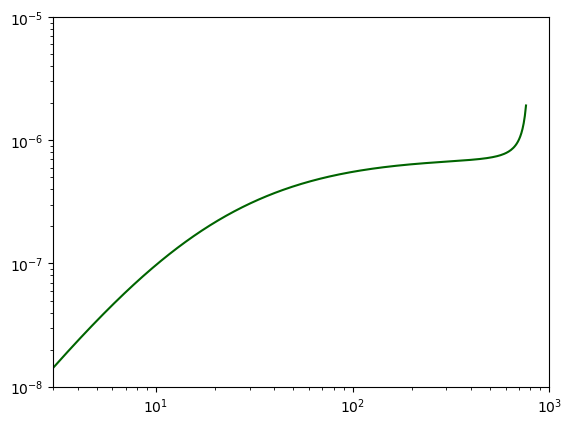

In [84]:
plt.loglog(d_arr, opt_depth_arr, color='darkgreen')
plt.ylim(1e-8, 1e-5)
plt.xlim(3, 1e3)
plt.show()

In [114]:
pbh_wide = Pbh(m_lens, 1, l=1.0, b=-1.03, ds=8.5, lognorm=True, sigma=1.)
pbh_med = Pbh(m_lens, 1, l=1.0, b=-1.03, ds=8.5, lognorm=True, sigma=0.5)



In [116]:
m_arr = np.logspace(-12, -1, 10000)
mass_func_arr = np.array([pbh.mass_function(m) for m in m_arr])
mass_func_arr_wide = np.array([pbh_wide.mass_function(m) for m in m_arr])
mass_func_arr_med = np.array([pbh_med.mass_function(m) for m in m_arr])


In [132]:
max1 = np.argmax(mass_func_arr)
max2 = np.argmax(mass_func_arr_wide)
print(mass_func_arr[max1]/ mass_func_arr_wide[max2])
# max(mass_func_arr)/max(mass_func_arr_wide)

6.095704732823721


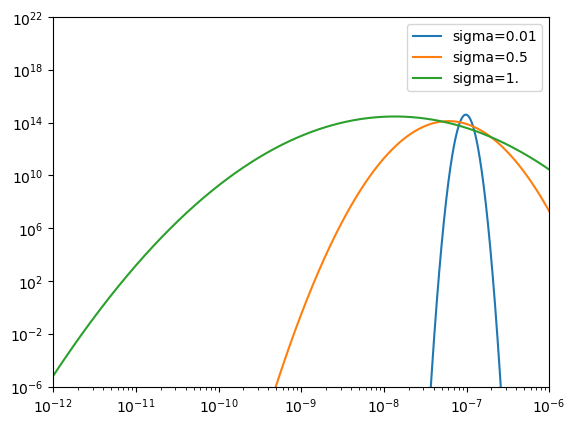

In [122]:
plt.loglog(m_arr, 1/m_arr*mass_func_arr, label="sigma=0.01")
plt.loglog(m_arr, 1/m_arr*mass_func_arr_med, label="sigma=0.5")
plt.loglog(m_arr, 1/m_arr*mass_func_arr_wide, label="sigma=1.")
plt.ylim(1e-6, 1e22)
plt.xlim(1e-12, 1e-6)
plt.legend()

In [120]:
max(1/m_arr*mass_func_arr_wide)/max(1/m_arr*mass_func_arr)

0.7242763612503668

In [121]:
max(1/m_arr*mass_func_arr_med)/max(1/m_arr*mass_func_arr)

0.32321539268840205

In [66]:
print(quad(lambda m: pbh.mass_function(m), 1e-10, 1e-6, epsabs=0, epsrel=1e-1)[0])
print(quad(lambda m: pbh_wide.mass_function(m), 1e-10, 1e-6, epsabs=0, epsrel=1e-1)[0])


0.9999999999999808
0.9893455792686998


In [63]:
#Why are these means different?
print(quad(lambda m: m * pbh.mass_function(m), 1e-10, 1e-5, epsabs=0, epsrel=1e-1)[0])
print(quad(lambda m: m * pbh_wide.mass_function(m), 1e-10, 1e-5, epsabs=0, epsrel=1e-1)[0])


1.0050125208600002e-07
1.648459526669144e-07


In [129]:
print(quad(lambda m: m**(-1) * pbh.mass_function(m), 1e-10, 1e-4, epsabs=0, epsrel=1e-1)[0])
print(quad(lambda m: m**(-1) * pbh_wide.mass_function(m), 1e-10, 1e-4, epsabs=0, epsrel=1e-1)[0])
print(quad(lambda m: m**(-1) * pbh_med.mass_function(m), 1e-10, 1e-4, epsabs=0, epsrel=1e-1)[0])


10050125.208942829
16488514.507231262
11331126.897983415


/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_19487/2337308567.py:3: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  print(quad(lambda m: m**(-1) * pbh_med.mass_function(m), 1e-10, 1e-4, epsabs=0, epsrel=1e-1)[0])


In [130]:
10050125.208597425/11331487.57518435 * 

0.886920198421867

In [131]:
10050125.208597425/16487189.28327144

0.6095717733279549

In [145]:
diff_rate_mono = np.array([pbh.differential_rate_mw(t, finite=False) for t in ts])
diff_rate_lognorm = np.array([pbh.differential_rate_mw_lognorm(t, finite=False) for t in ts])
diff_rate_lognorm_wide = np.array([pbh_wide.differential_rate_mw_lognorm(t, finite=False) for t in ts])


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


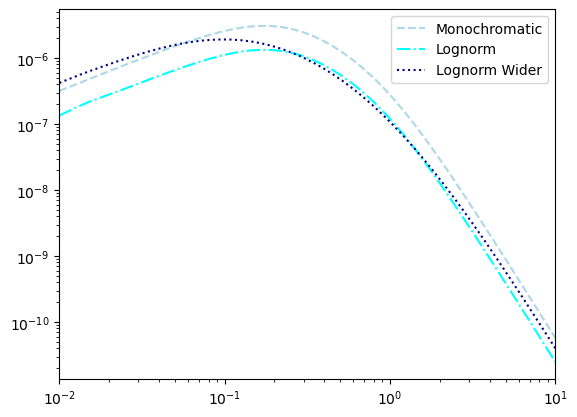

In [282]:
plt.loglog(ts, diff_rate_mono, label="Monochromatic", color="lightblue", linestyle="--")
plt.loglog(ts, diff_rate_lognorm, label="Lognorm", color="cyan", linestyle="-.")
plt.loglog(ts, diff_rate_lognorm_wide, label="Lognorm Wider", color="darkblue", linestyle=":")

plt.xlim(1e-2, 1e1)
# plt.ylim(1e-8, 1e-5)
plt.legend()
plt.show()

In [35]:
ts = np.logspace(-1,2,30)
diff_rate_mono_finite = np.array([pbh.differential_rate_mw(t, finite=True) for t in tqdm(ts)])
diff_rate_lognorm_finite = np.array([pbh.differential_rate_mw_lognorm(t, finite=True) for t in tqdm(ts)])
diff_rate_lognorm_wide_finite = np.array([pbh_wide.differential_rate_mw_lognorm(t, finite=True) for t in tqdm(ts)])

  0%|          | 0/30 [00:00<?, ?it/s]

  7%|▋         | 2/30 [01:11<16:51, 36.12s/it]/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_19487/1828157244.py:253: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(outer_integral, mf_min, mf_max, args=(t,), epsabs=epsabs, epsrel=epsrel)
100%|██████████| 30/30 [03:46<00:00,  7.55s/it]


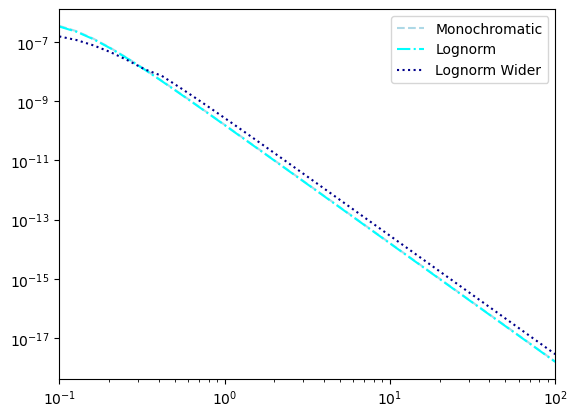

In [37]:
plt.loglog(ts, diff_rate_mono_finite, label="Monochromatic", color="lightblue", linestyle="--")
plt.loglog(ts, diff_rate_lognorm_finite, label="Lognorm", color="cyan", linestyle="-.")
plt.loglog(ts, diff_rate_lognorm_wide_finite, label="Lognorm Wider", color="darkblue", linestyle=":")

plt.xlim(1e-1, 1e2)
# plt.ylim(1e-8, 1e-5)
plt.legend()
plt.show()

In [7]:
#test object creation
test_eq(pbh.mass, m_lens)

#test differential rate
test_eq(pbh.differential_rate_total(1), pbh.differential_rate_mw(1) + pbh.differential_rate_m31(1))

#test that threshold parameter is close to 1 for small d
test_close(pbh.umin_upper_bound(0), 1, eps=1e-2)

#test that threshold parameter is close to 0 when close to source
test_close(pbh.umin_upper_bound(ds*0.99), 0, eps=1e-2)

#test that umin lower bound is correctly inherited from Lens
test_eq(pbh.umin_lower_bound(0), 0)

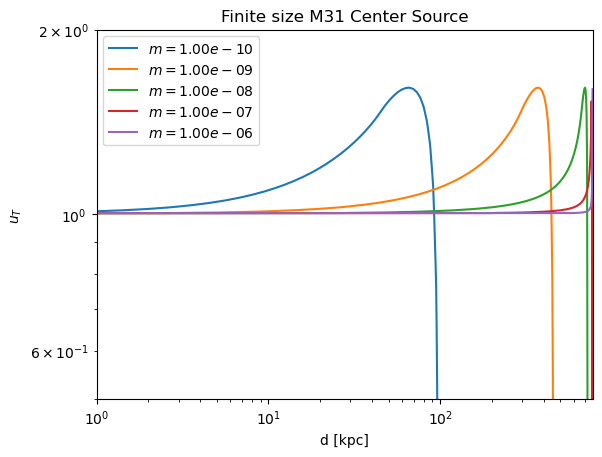

In [8]:
d_arr = np.logspace(0, np.log10(ds*0.999), 1000)

m_pbh_arr = np.logspace(-10, -6, 5)

rhos_calc = [[rho_func(m, d, ds) for d in d_arr] for m in m_pbh_arr]

for m, rhos in zip(m_pbh_arr, rhos_calc):
    plt.plot(d_arr, ut_func_new(rhos, 1.34), label=f"$m= {m:.2e}$")

plt.xscale("log")
plt.yscale("log")
plt.xlim(min(d_arr), max(d_arr))
plt.ylim(5e-1, 2)

plt.xlabel("d [kpc]")
plt.ylabel("$u_{T}$")
plt.title("Finite size M31 Center Source")

plt.legend()
plt.show()

In [765]:
result_mw = np.array([pbh.differential_rate_mw(t, finite=False) for t in ts])
result_m31 = np.array([pbh.differential_rate_m31(t, finite=False) for t in ts])

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the posi

In [767]:
result_mw_fwhm = np.array([pbh.differential_rate_mw(t, finite=False, t_fwhm=True) for t in ts])
result_m31_fwhm = np.array([pbh.differential_rate_m31(t, finite=False, t_fwhm=True) for t in ts])

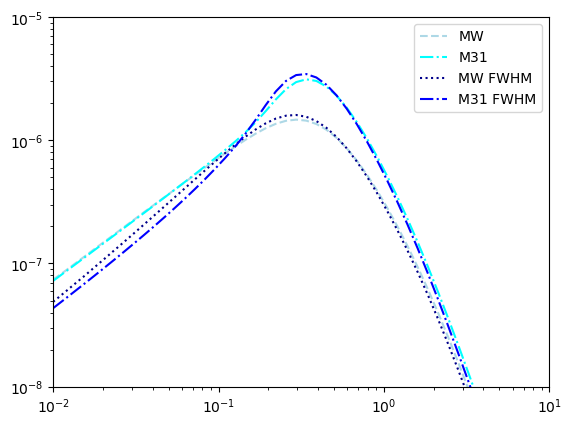

In [768]:
plt.loglog(ts, result_mw, label="MW", color="lightblue", linestyle="--")
plt.loglog(ts, result_m31, label="M31", color="cyan", linestyle="-.")

plt.loglog(ts, result_mw_fwhm, label="MW FWHM", color="darkblue", linestyle=":")
plt.loglog(ts, result_m31_fwhm, label="M31 FWHM", color="blue", linestyle="-.")

# plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total", color="blue")
plt.xlim(1e-2, 1e1)
plt.ylim(1e-8, 1e-5)
plt.legend()
plt.show()

In [11]:
result_mw_finite = np.array([pbh.differential_rate_mw(t, finite=True) for t in ts])
result_m31_finite = np.array([pbh.differential_rate_m31(t, finite=True) for t in ts])

In [1310]:
result_mw_finite_fwhm = np.array([pbh.differential_rate_mw(t, finite=True, t_fwhm=True) for t in ts])
result_m31_finite_fwhm = np.array([pbh.differential_rate_m31(t, finite=True, t_fwhm=True) for t in ts])

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [949]:
result_mw_finite_fwhm_pointuh = np.array([pbh.differential_rate_mw(t, finite=True, t_fwhm=True) for t in ts])
result_m31_finite_fwhm_pointuh = np.array([pbh.differential_rate_m31(t, finite=True, t_fwhm=True) for t in ts])

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [12]:
data = [
    [0.01025159072241831, 1.7621048479375022e-8],
    [0.011749210071050412, 2.275845926074791e-8],
    [0.013010968590057192, 2.8338767124544285e-8],
    [0.015172599513934704, 3.660092518663994e-8],
    [0.018150374932612852, 4.9935878934731396e-8],
    [0.021342877996043896, 6.689548786914154e-8],
    [0.024469204734566336, 8.329806647658273e-8],
    [0.030032772921632634, 1.1787686347935867e-7],
    [0.03592700699000345, 1.6082338776670456e-7],
    [0.04262892307911706, 2.0771139259664584e-7],
    [0.05469664912498203, 2.634116147541181e-7],
    [0.06900941075296256, 3.1622776601683855e-7],
    [0.08857560802715489, 3.866353752192416e-7],
    [0.12283421184247999, 5.085682063672464e-7],
    [0.15638060300786213, 5.886284783911139e-7],
    [0.20253712845316588, 6.938567878737194e-7],
    [0.2470358549514784, 7.602429140842648e-7],
    [0.2763758014285721, 8.030857221391537e-7],
    [0.31751457701013913, 8.030857221391537e-7],
    [0.3616892285784637, 7.88543029093589e-7],
    [0.41222248524188604, 7.329584652846327e-7],
    [0.45782876542269824, 6.689548786914153e-7],
    [0.5359170076153679, 5.779692884153325e-7],
    [0.6007544242560869, 4.948168092155156e-7],
    [0.6795358250644348, 4.084238652674534e-7],
    [0.7965346544989818, 3.0487862993011716e-7],
    [0.9256949197478721, 2.2551456856869547e-7],
    [1.1050115390216486, 1.536412870228796e-7],
    [1.2739795793681672, 1.056354103749187e-7],
    [1.488016811495529, 7.26291750173622e-8],
    [1.701175465649317, 4.858564096319701e-8],
    [1.9450364722110915, 3.2205979187210826e-8],
    [2.2432251551002356, 2.13483876067981e-8],
    [2.743761366010025, 1.0956769860448866e-8]
]

# Convert the data into numpy arrays
data_array = np.array(data)
x = data_array[:, 0]  # First column is x values
y = data_array[:, 1]  # Second column is y values

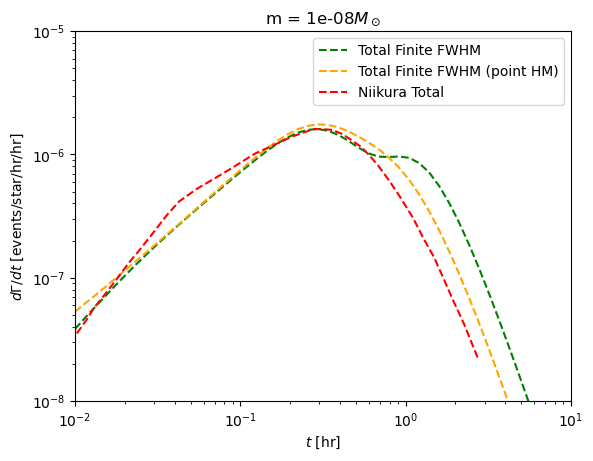

In [1420]:
# plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total, Point Source", color="lightgreen", linestyle="--")
# plt.loglog(ts, (result_mw_finite + result_m31_finite), label="Total Finite", color="blue")
# plt.loglog(ts, (result_mw_finite + result_m31_finite)/2, label="Total Finite/2", color="blue", ls='--')

plt.loglog(ts, (result_mw_finite_fwhm + result_m31_finite_fwhm), label="Total Finite FWHM", color="green", linestyle="--")
plt.loglog(ts, (result_mw_finite_fwhm_pointuh + result_m31_finite_fwhm_pointuh), label="Total Finite FWHM (point HM)", color="orange", linestyle="--")

# plt.loglog(ts, result_m31_finite_fwhm, label="M31 FWHM", color="green", linestyle="-.")

# plt.loglog(ts, result_mw_finite_fwhm, label="MW FWHM", color="lightblue", linestyle="--")
# plt.loglog(ts, result_m31_finite_fwhm, label="M31 FWHM", color="cyan", linestyle="-.")

plt.loglog(x, y*2, label="Niikura Total", color="Red", linestyle="--")

plt.xlim(1e-2, 1e1)
plt.ylim(1e-8, 1e-5)
plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.title("m = {}".format(pbh.mass) + r"$M_\odot$")
plt.legend()
plt.show()

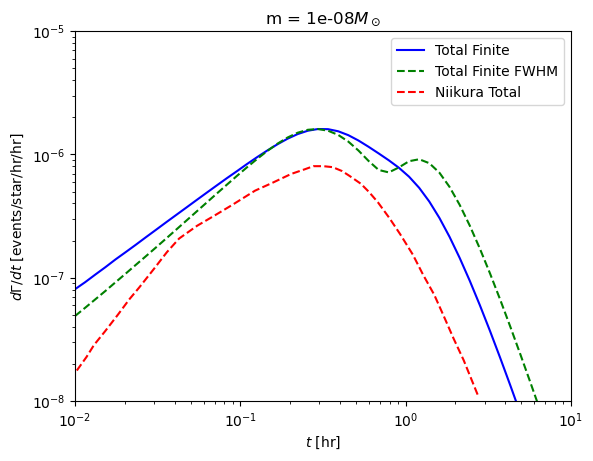

In [356]:
# plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total, Point Source", color="lightgreen", linestyle="--")
plt.loglog(ts, (result_mw_finite + result_m31_finite), label="Total Finite", color="blue")
# plt.loglog(ts, (result_mw_finite + result_m31_finite)/2, label="Total Finite/2", color="blue", ls='--')

plt.loglog(ts, (result_mw_finite_fwhm + result_m31_finite_fwhm), label="Total Finite FWHM", color="green", linestyle="--")
# plt.loglog(ts, result_m31_finite_fwhm, label="M31 FWHM", color="green", linestyle="-.")

# plt.loglog(ts, result_mw_finite, label="MW", color="lightblue", linestyle="--")
# plt.loglog(ts, result_m31_finite, label="M31", color="cyan", linestyle="-.")

plt.loglog(x, y, label="Niikura Total", color="Red", linestyle="--")

plt.xlim(1e-2, 1e1)
plt.ylim(1e-8, 1e-5)
plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.title("m = {}".format(pbh.mass) + r"$M_\odot$")
plt.legend()
plt.show()

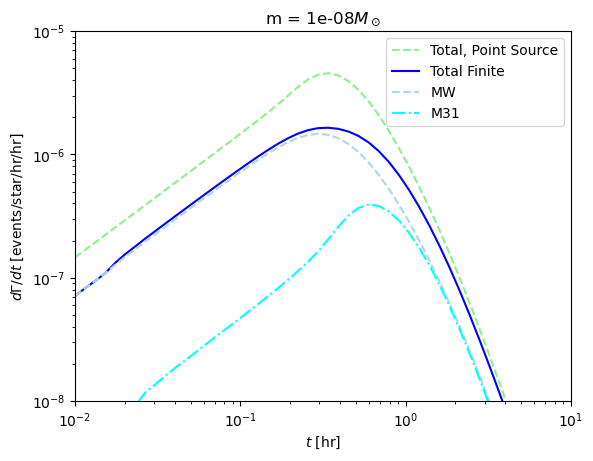

In [ ]:
plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total, Point Source", color="lightgreen", linestyle="--")
plt.loglog(ts, np.array(result_mw_finite) + np.array(result_m31_finite), label="Total Finite", color="blue")
plt.loglog(ts, result_mw_finite, label="MW", color="lightblue", linestyle="--")
plt.loglog(ts, result_m31_finite, label="M31", color="cyan", linestyle="-.")
plt.xlim(1e-2, 1e1)
plt.ylim(1e-8, 1e-5)
plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.title("m = {}".format(pbh.mass) + r"$M_\odot$")
plt.legend()
plt.show()

In [ ]:
ts = np.logspace(-2, 3, 30)
pbhs = [Pbh(10**(i), 1, l=l, b=b) for i in np.linspace(-5, -3, 3)]

result = np.zeros((len(pbhs), len(ts)))
for i, pbh in enumerate(pbhs):
    result[i] = pbh.compute_differential_rate(ts, finite=False)

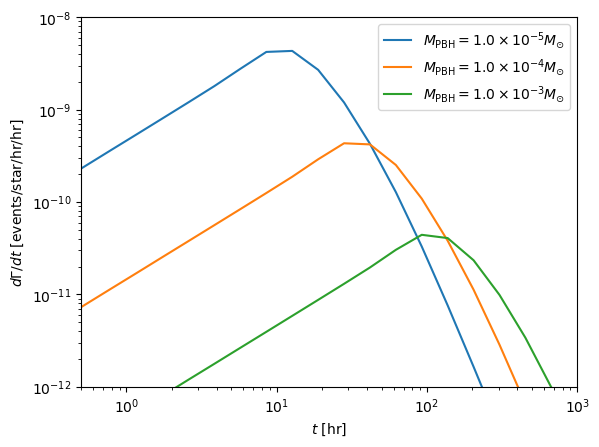

In [ ]:
for i, pbh in enumerate(pbhs):
    plt.loglog(ts, result[i], label=r"$M_{\rm{PBH}} = $" + scientific_format(pbh.mass,0) + "$M_{\odot}$")

plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.xlim(5e-1, 1e3)
plt.ylim(1e-12, 1e-8)

plt.legend()
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()